In [2]:
import pandas as pd
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


import matplotlib.pyplot as plt
import json

from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from keras_tuner import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters

from keras.utils.vis_utils import plot_model

/var/folders/22/c3r98x554qv7s1kh3_393tcm0000gn/T/ipykernel_46253/2888692820.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [3]:
# Read in the data
df = pd.read_csv("Resources/runner_result_runner_result.csv")
df = df.drop(columns="Unnamed: 0")
#df

In [4]:
# Convert categorical features to numerical
#weatherCondition = pd.get_dummies(df.weatherCondition, sparse=True)
#trackCondition = pd.get_dummies(df.trackCondition, sparse=True)
#meetingName = pd.get_dummies(df.meetingName, sparse=True)
#runnerNumber = pd.get_dummies(df.runnerNumber, sparse=True)
#raceClassConditions = pd.get_dummies(df.raceClassConditions, sparse=True)

In [5]:

# Dummified:      weather, track condition, meeting name
# label encoded:  race distance, raceClassConditions, horse name, trainer?, 

#already lavel encoded: track (runner placings), classStronger (runner wins), track (trainer placings), last12Months (trainer placings), last 12Months (rider placings)

In [6]:
import os
import json
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
label_encoder = LabelEncoder()

# 1. Dummify specified columns
dummified_columns = ["weatherCondition",]
df_dummies = pd.get_dummies(df[dummified_columns], drop_first=True)
df = pd.concat([df, df_dummies], axis=1)

# 2. Label encode specified columns
label_encode_columns = ["meetingName",
                        "raceClassConditions",
                        "runnerName",
                        "runnerNumber",
                        "trackCondition" 
                       ]
for col in label_encode_columns:
    df[f"{col}_encoded"] = label_encoder.fit_transform(df[col])



# 3. Save mappings to JSON file
all_transformed_columns = dummified_columns + label_encode_columns
all_mappings = {}
for col in all_transformed_columns:
    if col in dummified_columns:
        # For dummified columns, we'll store a list of the created dummy columns
        all_mappings[col] = df_dummies.filter(like=col).columns.tolist()
    else:
        # For label encoded columns, store a dictionary of the mappings
        all_mappings[col] = {str(key): int(value) for key, value in zip(df[col].unique(), label_encoder.fit_transform(df[col].unique()))}

# Get the current working directory
current_directory = os.getcwd()

# Save the mappings to a JSON file
with open(os.path.join(current_directory, 'all_mappings.json'), 'w') as file:
    json.dump(all_mappings, file)



In [7]:

# Features from one-hot encoding
dummified_features = df_dummies.columns.tolist()

# Features from label encoding (using the new column names with '_encoded' suffix)
encoded_features = [f"{col}_encoded" for col in label_encode_columns]

# Your list of features "from df"
from_df_features = [
    "raceDistance",
    "classSame (runner placings)",
    "classSame (runner wins)",                        
    "classStronger (runner placings)",
    "classStronger (runner wins)",
    "distance (runner placings)",
    "trackDistance (runner wins)",                        
    "last30Days (trainer placings)",
    "last30Days (trainer wins)",                        
    "last30Days (rider placings)",
    "last30Days (rider wins)",
    "firstUp (runner wins)",
    "secondUp (runner wins)",
    "last12Months (trainer placings)",
    "last12Months (trainer wins)",                        
    "last12Months (rider placings)",
    "last12Months (rider wins)",
    "overall (runner placings)",
    "firm (runner placings)",
    "good (runner placings)",
    "dead (runner placings)",
    "slow (runner placings)",
    "soft (runner placings)",
    "heavy (runner placings)",
    "overall (runner wins)",
    "firm (runner wins)",
    "good (runner wins)",
    "dead (runner wins)",
    "slow (runner wins)",
    "soft (runner wins)",
    "heavy (runner wins)"
]

# Combine all sets of features and the 'finishingPosition' column
features_of_interest = dummified_features + encoded_features + from_df_features + ['finishingPosition']

# Create the final dataframe
X = df[features_of_interest]

# Check the shape and head of the resultant dataframe
print(f"Shape of feature dataframe: {X.shape}")
#print(X.head())



Shape of feature dataframe: (13188, 40)


In [8]:
#Drop na's
X = X.dropna()
#X = X[X['finishingPosition'].isin([1.0,2.0,3.0,4.0])]
X

,weatherCondition_OCAST,weatherCondition_RAIN,weatherCondition_SHWRY,meetingName_encoded,raceClassConditions_encoded,runnerName_encoded,runnerNumber_encoded,trackCondition_encoded,raceDistance,classSame (runner placings),...,soft (runner placings),heavy (runner placings),overall (runner wins),firm (runner wins),good (runner wins),dead (runner wins),slow (runner wins),soft (runner wins),heavy (runner wins),finishingPosition
0,True,False,False,68,37,2876,2,3,1100,0,...,0,0,0,0,0,0,0,0,0,4.0
1,True,False,False,68,37,7051,10,3,1100,2,...,0,0,0,0,0,0,0,0,0,-2.0
2,True,False,False,68,37,1198,1,3,1100,0,...,0,0,0,0,0,0,0,0,0,0.0
3,True,False,False,68,37,5173,8,3,1100,1,...,0,0,0,0,0,0,0,0,0,-2.0
4,True,False,False,68,37,4381,7,3,1100,1,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13183,True,False,False,83,103,2555,4,4,1300,0,...,0,0,2,0,2,2,0,0,0,2.0
13184,True,False,False,83,103,6203,3,4,1300,0,...,2,0,1,0,1,1,0,0,0,4.0
13185,True,False,False,83,103,6035,6,4,1300,0,...,0,0,1,0,1,1,0,0,0,0.0
13186,True,False,False,83,103,2886,5,4,1300,0,...,0,0,1,0,1,0,0,0,0,1.0


In [9]:
#X['finishingPosition'].isin([1.0,2.0,3.0,4.0])

In [10]:
print(X.isnull().sum().sum())  # This will give the total number of NaN values in your DataFrame


0


In [11]:
# Convert finishingPosition to binary: 1 if the horse placed (1-4), 0 otherwise
X.loc[:, 'finishingPosition'] = X['finishingPosition'].apply(lambda x: 1 if 1.0 <= x <= 4.0 else 0)

# Let's look at just winning horses
# Convert finishingPosition to binary: 1 if the horse won (1st position), 0 otherwise
#X['finishingPosition'] = X['finishingPosition'].apply(lambda x: 1 if x == 1.0 else 0)


In [12]:
# Scale the data
scaled_data = StandardScaler().fit_transform(X)



In [13]:
k = list(range(1, 20))
inertia = []
for i in k:
    model = KMeans(n_clusters=i, random_state=0,n_init='auto')
    model.fit(scaled_data)
    inertia.append(model.inertia_)
    
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k,"inertia": inertia}

# Create a DataFrame with the data to plot the Elbow curve
df_elbow = pd.DataFrame(elbow_data)

In [14]:
elbow_plot = df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)
elbow_plot

:Curve   [k]   (inertia)

In [15]:
import seaborn as sns

In [16]:
#sns.pairplot(X)

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

market_pca_data = pca.fit_transform(scaled_data)
pca.explained_variance_ratio_

array([0.20681827, 0.11847198, 0.0671718 ])

In [18]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=10, random_state=0, n_init='auto')

# Fit the K-Means model using the scaled data
model.fit(scaled_data)

# Predict the clusters to group the horses using the scaled data
horse_clusters = model.predict(scaled_data)

# View the resulting array of cluster values.
print(horse_clusters)

# Create a copy of the DataFrame
scaled_predictions = X.copy()

# Add a new column to the DataFrame with the predicted clusters
scaled_predictions["horse_clusters"] = horse_clusters

# Display sample data
#scaled_predictions

[8 5 2 ... 5 2 2]


In [19]:
#clusters_plot = scaled_predictions.hvplot.scatter(
#    x="runnerName_encoded",
#    y="raceDistance",
#    by="horse_clusters",
#)
#clusters_plot

In [20]:
# Convert finishingPosition to binary: 1 if the horse placed (1-4), 0 otherwise
#X['finishingPosition'] = X['finishingPosition'].apply(lambda x: 1 if 1.0 <= x <= 3.0 else 0)


In [21]:
#X

In [22]:
from sklearn.model_selection import train_test_split

#Features and target variable
y = X['finishingPosition']
X_features = X.drop('finishingPosition', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=1)

In [23]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)


In [24]:
#keras tuner

import shutil

# Delete the tuner directory and its contents
tuner_dir = 'my_tuner_dir'
shutil.rmtree(tuner_dir, ignore_errors=True)

In [25]:

def build_model(hp: HyperParameters):
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Dense(units=hp.Int('input_units', min_value=32, max_value=512, step=32),
                           activation=hp.Choice('input_activation', values=['relu', 'tanh', 'sigmoid']),
                           input_dim=X_train.shape[1],
                           kernel_regularizer=keras.regularizers.l2(hp.Float('input_l2', 0.001, 0.1, step=0.001))))
    model.add(layers.Dropout(rate=hp.Float('input_dropout', min_value=0.0, max_value=0.5, step=0.05)))
    
    # Adding a variable number of hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int(f'hidden_units_{i}', min_value=32, max_value=512, step=32),
                               activation=hp.Choice(f'hidden_activation_{i}', values=['relu', 'tanh', 'sigmoid']),
                               kernel_regularizer=keras.regularizers.l2(hp.Float(f'hidden_l2_{i}', 0.001, 0.1, step=0.001))))
        model.add(layers.Dropout(rate=hp.Float(f'hidden_dropout_{i}', min_value=0.0, max_value=0.5, step=0.05)))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model



In [26]:
# Initialize early stopping callback
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Choose tuner
# Random Search
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=20, directory='my_tuner_dir', project_name='my_tuner_project')

# Bayesian Optimization
#tuner = BayesianOptimization(build_model, objective='val_accuracy', max_trials=30, directory='my_tuner_dir', project_name='my_tuner_project_bayesian')

# Searching for the best hyperparameters
tuner.search(X_train, y_train, epochs=25, validation_split=0.2, callbacks=[stop_early])


Trial 20 Complete [00h 00m 09s]
val_accuracy: 0.7202495336532593

Best val_accuracy So Far: 0.7202495336532593
Total elapsed time: 00h 02m 51s
INFO:tensorflow:Oracle triggered exit


In [27]:
best_model = tuner.get_best_models(num_models=1)[0]

In [28]:
eval_result = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {eval_result[1]}')


82/82 [==============================] - 0s 672us/step - loss: 0.6299 - accuracy: 0.7202
Test accuracy: 0.7201535701751709


In [29]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 384)               15360     
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                                 
 dense_1 (Dense)             (None, 416)               160160    
                                                                 
 dropout_1 (Dropout)         (None, 416)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                13344     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                1

In [30]:
layer_1_config = best_model.layers[0].get_config()
print(layer_1_config)

{'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 39), 'dtype': 'float32', 'units': 384, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 0.01899999938905239}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


In [31]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

{'input_units': 384, 'input_activation': 'sigmoid', 'input_l2': 0.019000000000000003, 'input_dropout': 0.2, 'num_layers': 3, 'hidden_units_0': 416, 'hidden_activation_0': 'sigmoid', 'hidden_l2_0': 0.032, 'hidden_dropout_0': 0.05, 'learning_rate': 0.001, 'hidden_units_1': 32, 'hidden_activation_1': 'relu', 'hidden_l2_1': 0.001, 'hidden_dropout_1': 0.0, 'hidden_units_2': 32, 'hidden_activation_2': 'relu', 'hidden_l2_2': 0.001, 'hidden_dropout_2': 0.0}


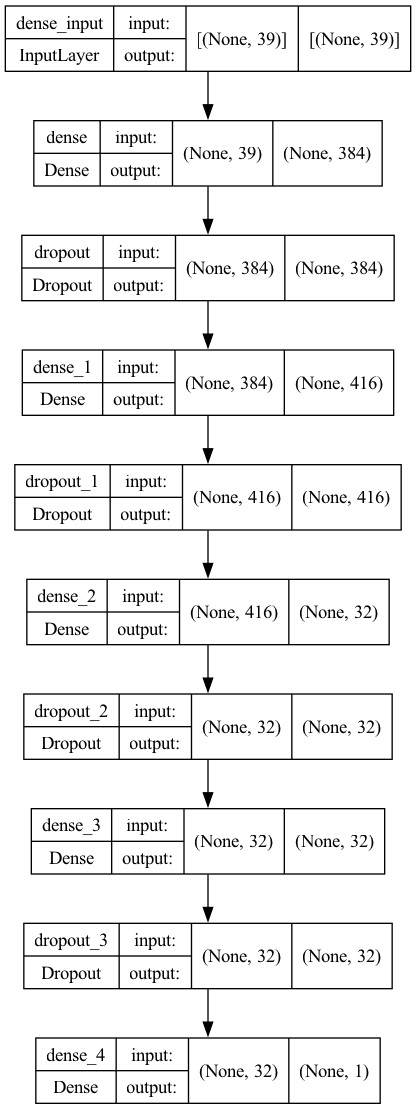

In [32]:
# Visualise the layers of the Keras Sequential Model

plot_model(best_model, to_file='best_model.png', show_shapes=True)


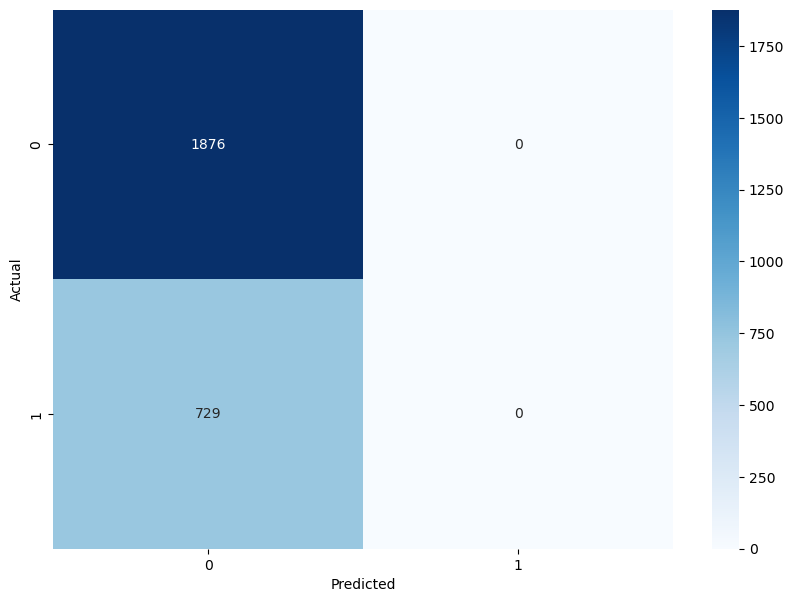

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the best model loaded and X_test is your test dataset
y_pred = best_model.predict(X_test)

# Convert probabilities to binary labels (e.g., using a threshold of 0.5)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [34]:
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense

# Initialize a Sequential model
#model = Sequential()

## Add layers to the model
#model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dense(12, activation='relu'))  # Hidden layer
#model.add(Dense(8, activation='relu'))  # Hidden layer
#model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [35]:
#history = model.fit(
#    X_train,
#    y_train,
#    epochs=20,
#    batch_size=16,
#    validation_data=(X_test, y_test)
#)


In [36]:
#loss, accuracy = model.evaluate(X_test, y_test)
#print(f"Test Loss: {loss:.4f}")
#print(f"Test Accuracy: {accuracy:.4f}")


In [37]:
#model.save("horsey_model_for_aws_v1.h5")

In [38]:
#y_pred_probs = model.predict(X_test)
#y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]


In [39]:
#plt.plot(y_pred_probs)

In [40]:
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred)


In [41]:
#import seaborn as sns
#import matplotlib.pyplot as plt


#plt.figure(figsize=(10,7))
#sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.show()


In [42]:
### RANDOM FOREST

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [44]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)

In [45]:
rf_model = rf_model.fit(X_train, y_train)

In [46]:
y_pred = rf_model.predict(X_test)

In [47]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7197696737044146

Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.96      0.83      1876
         1.0       0.50      0.11      0.18       729

    accuracy                           0.72      2605
   macro avg       0.62      0.53      0.51      2605
weighted avg       0.67      0.72      0.65      2605


Confusion Matrix:
 [[1793   83]
 [ 647   82]]


In [48]:
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': importances
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)


                            Feature  Importance
23    last12Months (rider placings)    0.064764
24        last12Months (rider wins)    0.064059
5                runnerName_encoded    0.063664
6              runnerNumber_encoded    0.056682
3               meetingName_encoded    0.054047
21  last12Months (trainer placings)    0.051768
22      last12Months (trainer wins)    0.049142
4       raceClassConditions_encoded    0.048233
17      last30Days (rider placings)    0.047140
8                      raceDistance    0.043426
18          last30Days (rider wins)    0.039393
7            trackCondition_encoded    0.037684
15    last30Days (trainer placings)    0.035501
16        last30Days (trainer wins)    0.028990
25        overall (runner placings)    0.027565
28           dead (runner placings)    0.022935
13       distance (runner placings)    0.022294
27           good (runner placings)    0.022215
9       classSame (runner placings)    0.021670
32            overall (runner wins)    0

In [49]:
#import matplotlib.pyplot as plt

# Sort feature importances in descending order and plot
#sorted_idx = importances.argsort()[::-1]
#plt.figure(figsize=(10, 12))
#plt.barh(X.columns[sorted_idx], importances[sorted_idx])
#plt.xlabel("Random Forest Feature Importance")
#plt.show()


In [50]:
print(feature_importance[0:30])

                            Feature  Importance
23    last12Months (rider placings)    0.064764
24        last12Months (rider wins)    0.064059
5                runnerName_encoded    0.063664
6              runnerNumber_encoded    0.056682
3               meetingName_encoded    0.054047
21  last12Months (trainer placings)    0.051768
22      last12Months (trainer wins)    0.049142
4       raceClassConditions_encoded    0.048233
17      last30Days (rider placings)    0.047140
8                      raceDistance    0.043426
18          last30Days (rider wins)    0.039393
7            trackCondition_encoded    0.037684
15    last30Days (trainer placings)    0.035501
16        last30Days (trainer wins)    0.028990
25        overall (runner placings)    0.027565
28           dead (runner placings)    0.022935
13       distance (runner placings)    0.022294
27           good (runner placings)    0.022215
9       classSame (runner placings)    0.021670
32            overall (runner wins)    0

In [51]:
feature_importance['Feature'][:50].to_list()

['last12Months (rider placings)',
 'last12Months (rider wins)',
 'runnerName_encoded',
 'runnerNumber_encoded',
 'meetingName_encoded',
 'last12Months (trainer placings)',
 'last12Months (trainer wins)',
 'raceClassConditions_encoded',
 'last30Days (rider placings)',
 'raceDistance',
 'last30Days (rider wins)',
 'trackCondition_encoded',
 'last30Days (trainer placings)',
 'last30Days (trainer wins)',
 'overall (runner placings)',
 'dead (runner placings)',
 'distance (runner placings)',
 'good (runner placings)',
 'classSame (runner placings)',
 'overall (runner wins)',
 'good (runner wins)',
 'soft (runner placings)',
 'dead (runner wins)',
 'classStronger (runner placings)',
 'slow (runner placings)',
 'heavy (runner placings)',
 'soft (runner wins)',
 'firstUp (runner wins)',
 'secondUp (runner wins)',
 'weatherCondition_OCAST',
 'trackDistance (runner wins)',
 'slow (runner wins)',
 'weatherCondition_SHWRY',
 'classSame (runner wins)',
 'classStronger (runner wins)',
 'heavy (runne

In [52]:
#X = X[feature_importance['Feature'][:20].to_list()]

In [53]:
#unique_values = {column: X[column].unique().tolist() for column in X.columns}


In [ ]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import json
from keras.models import load_model
import time

def run_prediction():
    # Load your model
    model = load_model("horsey_model_for_aws_v1.h5")
    # Create a dummy prediction input based on your actual model's input structure
    # For this example, I'm assuming it's a single array with the encoded values
    prediction_input = [
        input_data['runnerName_encoded'],
        input_data['weatherCondition_encoded'],
        input_data['trackCondition_encoded'],
        input_data['raceClassConditions_encoded'],
        input_data['runnerNumber_encoded'],
        int(input_data['raceDistance'])
    ]
    # Predict
    prediction = model.predict([prediction_input])
    # Clear the window and display the result
    for widget in root.winfo_children():
        widget.destroy()
    if prediction == 1:
        ttk.Label(root, text="WE HAVE A WINNER").grid(column=1, row=1)
    else:
        ttk.Label(root, text="SORRY, YOU ARE A LOSER").grid(column=1, row=1)
    ttk.Button(root, text="Go back", command=show_selection_interface).grid(column=1, row=2)


def countdown():
    for widget in root.winfo_children():
        widget.destroy()
    for i in range(3, 0, -1):
        ttk.Label(root, text=f"Fantastic... running prediction model in {i}...").grid(column=1, row=1)
        root.update()
        time.sleep(1.5)
    run_prediction()

def summary_screen():
    for widget in root.winfo_children():
        widget.destroy()
    ttk.Label(root, text="Congratulations, you have selected:").grid(column=1, row=0)
    for index, (key, value) in enumerate(input_data.items()):
        if key in label_encoded_columns:  # Use the original key name for display (without '_encoded')
            key_display = key.replace('_encoded', '')
            ttk.Label(root, text=f"{key_display}: {inverse_mappings[key][value]}").grid(column=1, row=index + 1)
        else:
            ttk.Label(root, text=f"{key}: {value}").grid(column=1, row=index + 1)
    row_for_text = len(input_data) + 2
    ttk.Label(root, text="").grid(column=1, row=row_for_text)  # Empty line
    ttk.Label(root, text="Are you ready to predict if this horse will place?").grid(column=1, row=row_for_text + 1, columnspan=2)
    ttk.Button(root, text="YES", command=countdown).grid(column=1, row=row_for_text + 2)
    ttk.Button(root, text="NO", command=show_selection_interface).grid(column=2, row=row_for_text + 2)



def confirm_selection():
    for widget in root.winfo_children():
        widget.destroy()
    ttk.Label(root, text="Congratulations, you have selected:").grid(column=1, row=0)
    for index, (key, value) in enumerate(input_data.items()):
        if key in label_encoded_columns:  # Use the original key name for display (without '_encoded')
            key_display = key.replace('_encoded', '')
            ttk.Label(root, text=f"{key_display}: {inverse_mappings[key][value]}").grid(column=1, row=index + 1)
        else:
            ttk.Label(root, text=f"{key}: {value}").grid(column=1, row=index + 1)
    row_for_text = len(input_data) + 2
    ttk.Label(root, text="").grid(column=1, row=row_for_text)  # Empty line
    ttk.Label(root, text="Are you ready to predict if this horse will place?").grid(column=1, row=row_for_text + 1, columnspan=2)
    ttk.Button(root, text="YES", command=countdown).grid(column=1, row=row_for_text + 2)
    ttk.Button(root, text="NO", command=show_selection_interface).grid(column=2, row=row_for_text + 2)


def get_input_values():
    global input_data
    input_data = {}
    for column, dropdown in dropdowns.items():
        selected_value = dropdown.get()
        if column in label_encoded_columns:
            mapping_file = f"{column}_to_label_mapping.json"
            with open(mapping_file, 'r') as file:
                mapping = json.load(file)
            input_data[column + '_encoded'] = mapping[selected_value]
        else:
            input_data[column] = selected_value  # Ensure we're storing non-encoded values directly

def submit_button_clicked():
    get_input_values()
    summary_screen()

def show_selection_interface():
    for widget in root.winfo_children():
        widget.destroy()
    for index, (column, values) in enumerate(columns.items()):
        ttk.Label(root, text=f"{column}:").grid(column=1, row=index + 1, sticky=tk.W)
        dropdown_var = tk.StringVar()
        dropdown = ttk.Combobox(root, textvariable=dropdown_var)
        dropdown['values'] = values
        dropdown.grid(column=2, row=index + 1)
        dropdowns[column] = dropdown_var

    # Submit button
    ttk.Button(root, text="Submit", command=submit_button_clicked).grid(column=1, row=len(columns) + 2, columnspan=2)

columns = {
    'runnerName': sorted(df['runnerName'].dropna().unique().tolist()),
    'weatherCondition': sorted(df['weatherCondition'].dropna().unique().tolist()),
    'raceClassConditions': sorted(df['raceClassConditions'].dropna().unique().tolist()),
    'trackCondition': sorted(df['trackCondition'].dropna().unique().tolist()),
    'runnerNumber': sorted(df['runnerNumber'].dropna().unique(), key=int),  # assuming runnerNumber is an integer
    'raceDistance': sorted(df['raceDistance'].dropna().unique(), key=int)  # assuming raceDistance is an integer
}


# Load your dataframe, define columns, dropdowns and inverse mappings
# Here, I'm assuming you've already loaded 'df' and other required variables
inverse_mappings = {col: {v: k for k, v in json.load(open(f"{col}_to_label_mapping.json")).items()} for col in label_encoded_columns}

# Define the GUI components
root = tk.Tk()
root.geometry("400x400")  
root.title("Model Input GUI")
dropdowns = {}
show_selection_interface()
root.mainloop()


In [ ]:
import os
print("Current working directory:", os.getcwd())
